# Generate synthetic lightcurves
Sample from parameters of all 78 Gaussian Processes to generate synthetic lightcurves.


Add uncorrelated noise by:
   - Fit GP to each lightcurve
   - Define distribution over GP parameters
   - Create histogram of residuals (how many of each amplitude)
   - Define cutoff as 3 sigma
   - Add all cutoff 'tails' to create an 'average' noise distribution

In [1]:
# imports
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import gpytorch
import matplotlib.pyplot as plt
import scipy.stats

from dipper.data_utils.utils import *
from dipper.model_utils.gp_model import *
from sklearn.mixture import GaussianMixture
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.kernels import Kernel, PeriodicKernel, RBFKernel, ScaleKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval, Positive, GreaterThan, LessThan

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Single lightcurve

### Functions

In [2]:
# Load and clean K2 data
def load_k2_data(filename):
    fits_file = fits.open(filename)

    # Load data
    data = fits_file[1].data
    time = np.array(data['TIME'])
    pdc_flux = np.array(data['PDCSAP_FLUX'])*1.
    pdc_err = np.array(data['PDCSAP_FLUX_ERR'])*1.

    # Set x, y, and error
    x = time
    y = pdc_flux / np.nanmedian(pdc_flux)
    y_err = pdc_err / np.nanmedian(pdc_flux)

    # Clean
    clean = ((y < 1.5) & (y > 0.5) & (y_err > 0.))
    x = x[clean]
    y = y[clean]
    y_err = np.abs(y_err[clean]) 

    # Shift to start at time 0
    x = x - np.min(x)

    # Bin to 30-minute cadence
    num_bins = int(np.floor((np.max(x) - np.min(x)) * 48) + 1) # 48 bins per day
    x_bins = np.min(x) + np.arange(num_bins + 1) / 48.
    num_binned, bin_edges = np.histogram(x, bins= x_bins)
    num_binned = np.array(num_binned)
    y_binned, bin_edges = np.histogram(x, bins = x_bins, weights = y)
    var_binned, bin_edges = np.histogram(x, bins = x_bins, weights= 1 / y_err**2)

    # Where var_binned is 0, set to min value of var_binned
    var_binned[var_binned == 0] = np.min(var_binned[var_binned > 0])
    
    y_err_binned = 1 / np.sqrt(np.array(var_binned))
    y_binned = np.array(y_binned)
    y_binned = y_binned / (num_binned + 0.001)
    x_binned = x_bins[0:num_bins] + (x_bins[1] - x_bins[0]) / 2. 
    x = x_binned
    y = y_binned
    y_err = y_err_binned

    # Clean
    clean = ((y > 0.) & ~np.isnan(y_err) & (y_err > 0.))
    x = x[clean]
    y = y[clean]
    y_err = y_err[clean]

    assert len(x) == len(y) == len(y_err), 'Lengths of x, y, and y_err must be the same'

    return x, y, y_err

In [3]:
# Create a Quasi-Periodic Kernel
class QuasiPeriodicKernel(Kernel):
    def __init__(self, periodic_kernel=None, rbf_kernel=None, **kwargs):
        super(QuasiPeriodicKernel, self).__init__(**kwargs)
        if periodic_kernel is None:
            self.periodic_kernel = PeriodicKernel(**kwargs)
        else:
            self.periodic_kernel = periodic_kernel
        
        if rbf_kernel is None:
            self.rbf_kernel = RBFKernel(**kwargs)
        else:
            self.rbf_kernel = rbf_kernel

    def forward(self, x1, x2, diag=False, **params):
        periodic_part = self.periodic_kernel.forward(x1, x2, diag=diag, **params)
        rbf_part = self.rbf_kernel.forward(x1, x2, diag=diag, **params)
        return periodic_part * rbf_part

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel, mean):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [30]:
# Function to train GP model
def train_gp(
        x_train, 
        y_train, 
        training_iterations=50, 
        lr=0.1,
        device=torch.device("cpu"), 
        likelihood=None,
        kernel=None,
        mean=None,
        early_stopping=False,
        plot=False
    ):

    # Initialize likelihood
    if likelihood is not None:
        likelihood = likelihood.to(device)
        
    else:
        print("No likelihood specified. Using Gaussian likelihood.")
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Initialize model
    if kernel is not None:
        model = ExactGPModel(
            x_train, 
            y_train, 
            likelihood, 
            kernel,
            mean
        ).to(device)

    else:
        print("No kernel specified. Using Quasi-Periodic Kernel with no priors or constraints.")
        model = ExactGPModel(
            x_train, 
            y_train, 
            likelihood,
            ScaleKernel(QuasiPeriodicKernel()),
            ConstantMean()            
        ).to(device)

    # Find optimal hyperparameters
    model.train()
    likelihood.train()

    # Set optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Plot loss during training
    mll_losses = []
    mse_losses = []
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(x_train)
        mll_loss = -mll(output, y_train)
        mse_loss = torch.nn.functional.mse_loss(output.mean, y_train)

        # Early stopping
        if early_stopping:
            if i > 300 and mll_loss - mll_losses[i-100] > 0:
                print(f"Early stopping at iteration {i}")
                break

        mll_loss.backward()
        optimizer.step()
        mll_losses.append(mll_loss.item())
        mse_losses.append(mse_loss.item())

    if plot:
        # Plot the loss
        plt.figure(figsize=(10,5))
        plt.plot(range(len(mll_losses)), mll_losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("MLL Loss")
        plt.show()

        # Plot the loss
        plt.figure(figsize=(10,5))
        plt.plot(range(len(mse_losses)), mse_losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("MSE Loss")
        plt.show()

        # Plot the covariance matrices
        with torch.no_grad():
            periodic_cov = model.covar_module.base_kernel.periodic_kernel(torch.tensor(x).to(device)).evaluate()
            rbf_cov = model.covar_module.base_kernel.rbf_kernel(torch.tensor(x).to(device)).evaluate()

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Periodic Kernel Covariance")
        plt.imshow(periodic_cov.cpu().numpy(), cmap='viridis')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.title("RBF Kernel Covariance")
        plt.imshow(rbf_cov.cpu().numpy(), cmap='viridis')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.title("RBF * Periodic Kernel Covariance")
        plt.imshow(rbf_cov.cpu().numpy() * periodic_cov.cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.show()

    return model, likelihood, mll

### Load the data

Dominant period: 0.42232789855072467
Maximum absolute value of y: 2.7436326139591167


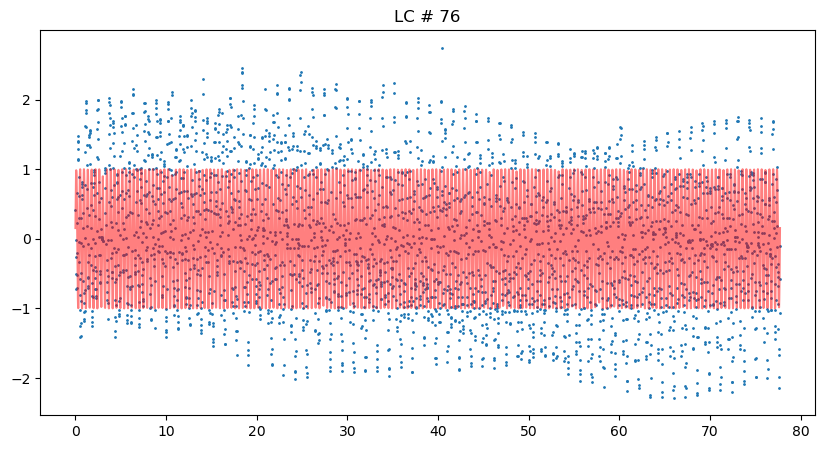

In [31]:
# Load the data
file_number = 76
data_dir = '../../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Find period of the light curve and convert from index to days (what x is in)
period = get_dom_period(y)
period = period * (x[-1] - x[0]) / len(x)
print(f"Dominant period: {period}")
sinusoid = np.sin(2 * np.pi * x / period)

# Print max and min of y
print(f"Maximum absolute value of y: {np.max(abs(y))}")

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2)
plt.plot(x, sinusoid, 'r', alpha=0.5)
plt.title(f"LC # {file_number}")
plt.show()

### Fit GP

Early stopping at iteration 302


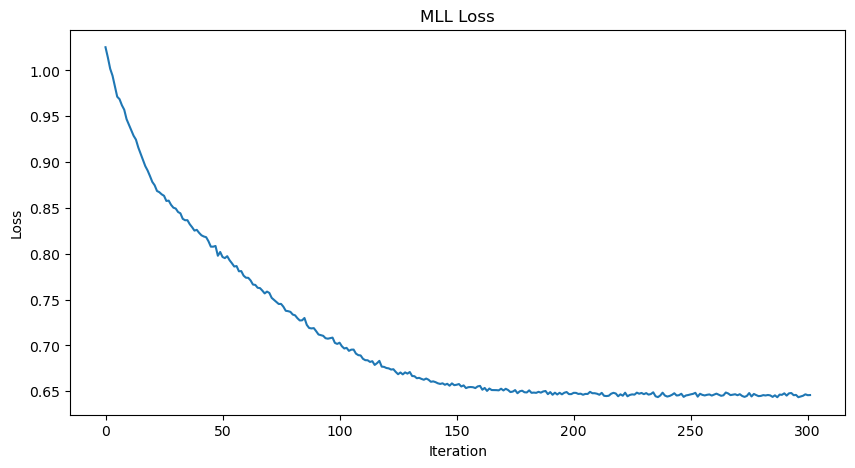

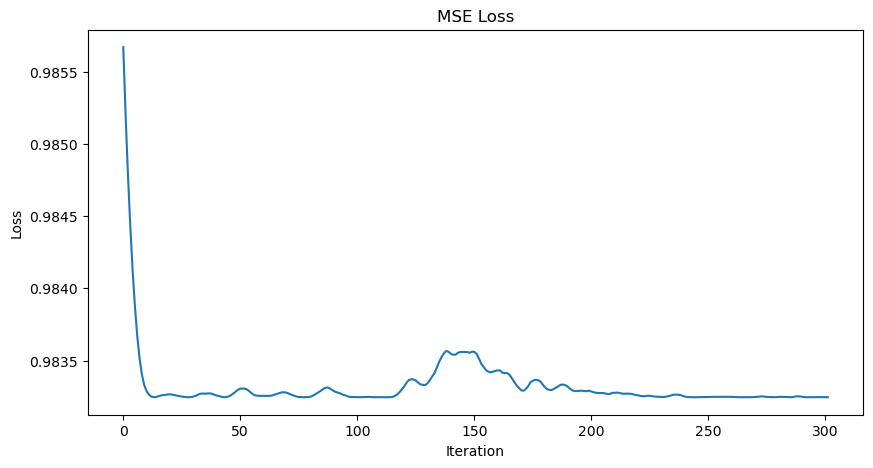

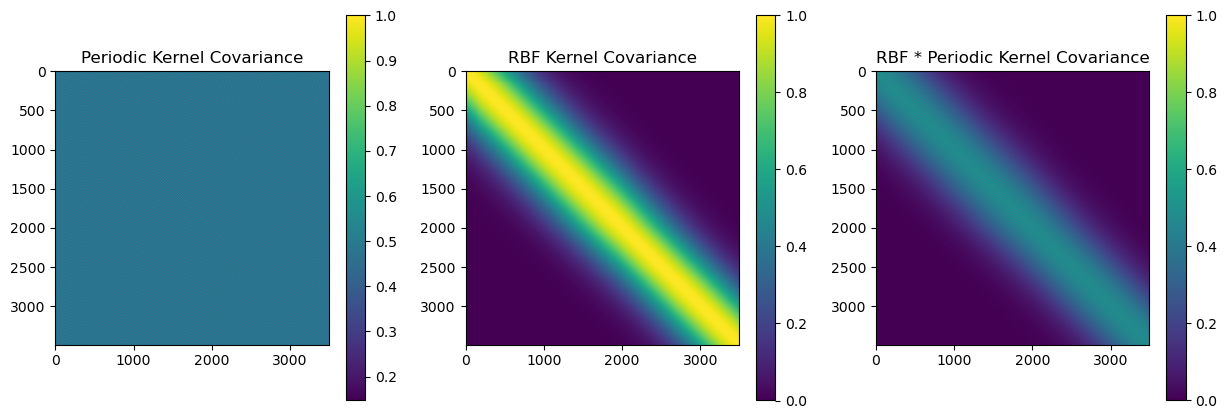

In [32]:
# Remove data between a range
lower = 10
upper = 20
x_new = x[(x < lower) | (x > upper)]
y_new = y[(x < lower) | (x > upper)]
y_err_new = y_err[(x < lower) | (x > upper)]

# Hyperparameters
training_iterations = 1_000
lr = 0.01

# noise_variances = torch.tensor(y_err_new, dtype=torch.float32).to(device) ** 2
# likelihood = FixedNoiseGaussianLikelihood(
#     noise=noise_variances, 
#     learn_additional_noise=True
# )

likelihood = GaussianLikelihood(
    noise_constraint=GreaterThan(lower_bound=0.0001)
).to(device)

kernel = QuasiPeriodicKernel(
    periodic_kernel=PeriodicKernel(
        period_length_constraint=Interval(lower_bound=max(period - 2.0, 0.4), upper_bound=(period + 2.0), initial_value=period), 
        lengthscale_constraint=Interval(lower_bound=min(period/2, 5), upper_bound=min(period*4, 10), initial_value=period)
    ),
    rbf_kernel=RBFKernel(
        lengthscale_constraint=GreaterThan(lower_bound=min(5*period, 5), initial_value=10)
    )
)

kernel = ScaleKernel(
    kernel, 
    outputscale_constraint=LessThan(upper_bound=min(max(abs(y)) + 1, 5), initial_value=1)                 
)

mean = ConstantMean(
    constant_constraint = Interval(lower_bound=-1, upper_bound=1, initial_value=0)
)

# Train GP model
model, likelihood, mll = train_gp(
    torch.tensor(x_new, dtype=torch.float32).to(device),
    torch.tensor(y_new, dtype=torch.float32).to(device), 
    training_iterations=training_iterations, 
    lr=lr,
    device=device,
    likelihood=likelihood,
    kernel=kernel,
    mean=mean,
    early_stopping=True,
    plot=True
)

likelihood.noise_covar.raw_noise: -1.5056262016296387
mean_module.raw_constant: -0.09937087446451187
covar_module.raw_outputscale: -3.401555299758911
covar_module.base_kernel.periodic_kernel.raw_lengthscale: 0.25270527601242065
covar_module.base_kernel.periodic_kernel.raw_period_length: -4.179866313934326
covar_module.base_kernel.rbf_kernel.raw_lengthscale: 8.65466022491455

Learned GP parameters:
Mean Constant:  -0.049644649028778076
Outputscale:  0.3092989921569824
Additional Noise:  0.20048928
Period:  0.43047642707824707
Periodic Lengthscale:  1.0431278944015503
RBF Lengthscale:  10.766473770141602


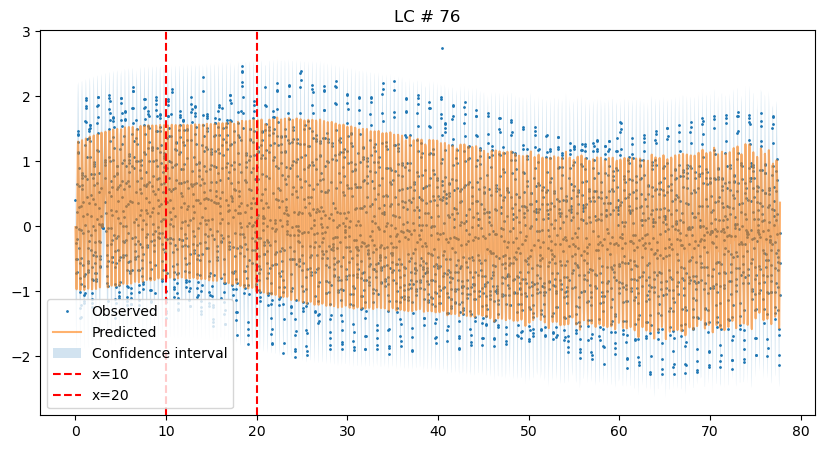

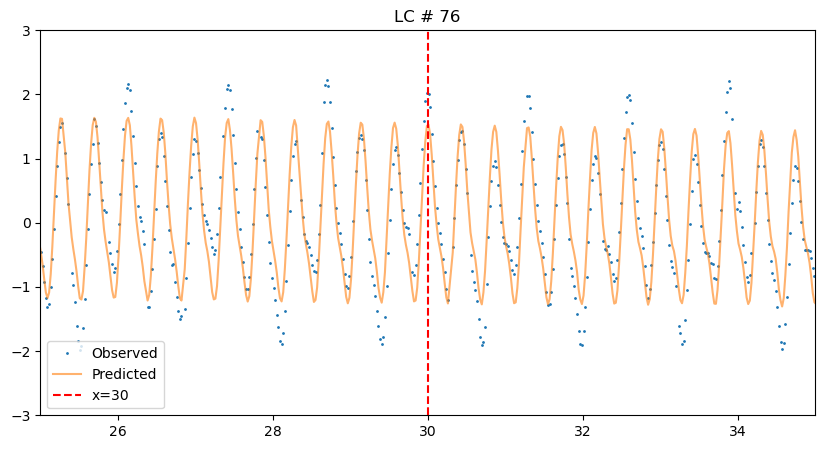

In [33]:
# Print learned GP parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data.item()}")

noises = model.likelihood.noise.squeeze().detach().cpu().numpy()
outputscale = model.covar_module.outputscale.item()
mean_constant = model.mean_module.constant.item()
period = model.covar_module.base_kernel.periodic_kernel.period_length.item()
periodic_lengthscale = model.covar_module.base_kernel.periodic_kernel.lengthscale.item()
rbf_lengthscale = model.covar_module.base_kernel.rbf_kernel.lengthscale.item()

print("\nLearned GP parameters:")
print("Mean Constant: ", mean_constant)
print("Outputscale: ", outputscale)
print("Additional Noise: ", noises)
print("Period: ", period)
print("Periodic Lengthscale: ", periodic_lengthscale)
print("RBF Lengthscale: ", rbf_lengthscale)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.tensor(x, dtype=torch.float32).to(device)))
    samples = predictions.sample(sample_shape=torch.Size([3]))
    mean = predictions.mean.cpu().numpy()
    variance = predictions.variance.cpu().numpy()
    stddev = np.sqrt(variance)

upper_ci, lower_ci = predictions.confidence_region()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, '.', markersize=2, label='Observed')
plt.plot(x, mean, label='Predicted', alpha=0.6)
plt.fill_between(x, lower_ci.cpu().numpy(), upper_ci.cpu().numpy(), alpha=0.2, label='Confidence interval')
plt.axvline(lower, color='r', linestyle='--', label=f'x={lower}')
plt.axvline(upper, color='r', linestyle='--', label=f'x={upper}')
plt.legend()
plt.title(f"LC # {file_number}")

plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2, label='Observed')
plt.plot(x, mean, label='Predicted', alpha=0.6)
plt.axvline(30, color='r', linestyle='--', label=f'x=30')
plt.xlim(25, 35)
plt.ylim(-3, 3)
plt.legend()
plt.title(f"LC # {file_number}")
plt.show()

In [46]:
# Calculate residuals
residuals = np.abs((mean - y))
cutoff = 3*stddev
cutoff_mean = 3*np.mean(stddev)
high_residuals = residuals[residuals > cutoff]
print(f"Number of high residuals: {len(high_residuals)}")
print(f"cutoff_mean: {cutoff_mean}")

# Plot histogram of residuals
# plt.figure(figsize=(10,5))
# plt.hist(residuals, bins=100)
# plt.xlabel("Residuals")
# plt.ylabel("Frequency")
# plt.yscale('log')
# plt.title("Histogram of residuals")
# plt.axvline(x=cutoff_mean, color='r', linestyle='--', label=f'cutoff_mean')
# plt.legend()
# plt.show()

Number of high residuals: 167
cutoff_mean: 0.5348758846521378


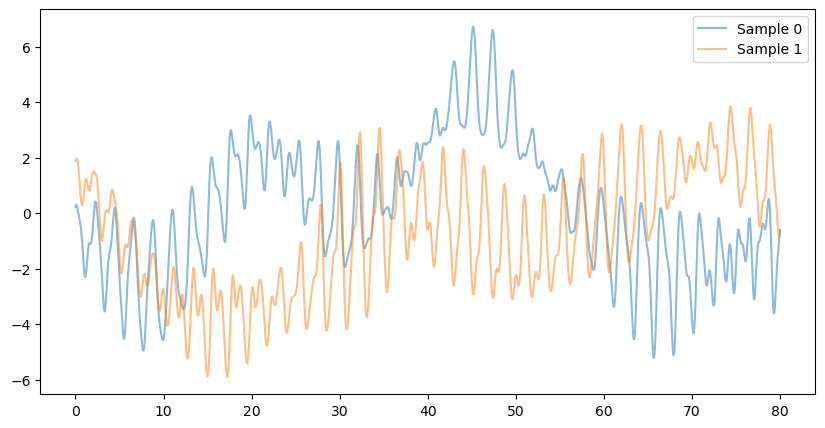

In [47]:
# Initialize new gp model with the learned parameters
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
likelihood.noise = np.mean(noises)

# Get GP model
kernel = ParameterizedQuasiPeriodicKernel(period, periodic_lengthscale, rbf_lengthscale).to(device)
model = ParameterizedGPModel(kernel, mean_constant, outputscale, likelihood).to(device)

# Generate predictions
model.eval()
model.likelihood.eval()

# Sample from the GP
num_samples = 2
x_sample = torch.linspace(0, 80, 3500).to(device)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model(x_sample)
    samples = model.likelihood(model(x_sample)).sample(sample_shape=torch.Size([num_samples]))
    mean = predictions.mean.cpu().numpy()
    variance = predictions.variance.cpu().numpy()
    stddev = np.sqrt(variance)

# Plot
plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x_sample.cpu().numpy(), samples[i].cpu().numpy(), alpha=0.5, label=f'Sample {i}')
plt.legend()
plt.show()

## Create distribution over all 78 lightcurves

### Create list of GP learned parameters and high_residuals for each lightcurve

In [61]:
# Initialize lists
mean_constants = []
outputscales = []
periodic_lengthscales = []
period_lengths = []
rbf_lengthscales = []
noises = []
high_residuals = []

# Hyperparameters
training_iterations = 1_000
lr = 0.01
residuals_cutoff = 3

# Load each file, train GP, append values to lists of GP parameters and tail distribution
for file_number in range(78):
    print(f"File number: {file_number}")
    # Load the data
    data_dir = '../../data/k2/'
    filename = f'k2_{file_number}.fits'
    x, y, y_err = load_k2_data(data_dir + filename)

    # Scale data to be between 0 and 1
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    y_err = y_err / (np.max(y) - np.min(y))

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Get dominant period to be initial period_length value
    period = get_dom_period(y)
    period = period * (x[-1] - x[0]) / len(x)
    
    # Initialize likelihood, kernel, and mean
    likelihood = GaussianLikelihood(
        noise_constraint=GreaterThan(lower_bound=0.0001)
    ).to(device)

    kernel = QuasiPeriodicKernel(
        periodic_kernel=PeriodicKernel(
            period_length_constraint=Interval(lower_bound=max(period - 2.0, 0.4), upper_bound=(period + 2.0), initial_value=period), 
            lengthscale_constraint=Interval(lower_bound=period/2, upper_bound=period*2, initial_value=period)
        ),
        rbf_kernel=RBFKernel(
            lengthscale_constraint=GreaterThan(lower_bound=min(5*period, 5), initial_value=10)
        )
    )

    kernel = ScaleKernel(
        kernel, 
        outputscale_constraint=LessThan(upper_bound=min(max(abs(y)) + 1, 5))                 
    )

    mean = ConstantMean(
        constant_constraint = Interval(lower_bound=-1, upper_bound=1)
    )

    # Train GP model
    model, likelihood, mll = train_gp(
        torch.tensor(x_new, dtype=torch.float32).to(device),
        torch.tensor(y_new, dtype=torch.float32).to(device), 
        training_iterations=training_iterations, 
        lr=lr,
        device=device,
        likelihood=likelihood,
        kernel=kernel,
        mean=mean,
        early_stopping=True,
        plot=False
    )

    # Evaluate model and append high residuals to list
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(torch.tensor(x, dtype=torch.float32).to(device)))
        mean = predictions.mean.cpu().numpy()
        variance = predictions.variance.cpu().numpy()
        stddev = np.sqrt(variance)

    residuals = np.abs((mean - y))
    curr_high_residuals = residuals[residuals > residuals_cutoff * stddev]
    high_residuals.extend(curr_high_residuals)

    # Append GP parameters to lists
    mean_constants.append(model.mean_module.constant.item())
    outputscales.append(model.covar_module.outputscale.item())
    periodic_lengthscales.append(model.covar_module.base_kernel.periodic_kernel.lengthscale.item())
    period_lengths.append(model.covar_module.base_kernel.periodic_kernel.period_length.item())
    rbf_lengthscales.append(model.covar_module.base_kernel.rbf_kernel.lengthscale.item())
    noises.append(np.mean(model.likelihood.noise.squeeze().detach().cpu().numpy()))

File number: 0


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/operators/added_diag_linear_operator.py:128: NumericalWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  warnings.warn(


Early stopping at iteration 360
File number: 1
Early stopping at iteration 103
File number: 2
Early stopping at iteration 101
File number: 3
Early stopping at iteration 106
File number: 4
Early stopping at iteration 104
File number: 5
Early stopping at iteration 493
File number: 6
Early stopping at iteration 387
File number: 7
Early stopping at iteration 272
File number: 8
Early stopping at iteration 277
File number: 9
Early stopping at iteration 393
File number: 10
Early stopping at iteration 101
File number: 11
Early stopping at iteration 275
File number: 12
Early stopping at iteration 292
File number: 13
Early stopping at iteration 101
File number: 14
Early stopping at iteration 102
File number: 15
Early stopping at iteration 448


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16824.45703125 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


File number: 16
Early stopping at iteration 360
File number: 17
Early stopping at iteration 354
File number: 18
Early stopping at iteration 356
File number: 19
Early stopping at iteration 448
File number: 20
Early stopping at iteration 429
File number: 21
Early stopping at iteration 411
File number: 22
Early stopping at iteration 443


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.08150451630353928 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


File number: 23
Early stopping at iteration 458


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1646.4791259765625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


File number: 24
Early stopping at iteration 444
File number: 25
Early stopping at iteration 501
File number: 26
Early stopping at iteration 512
File number: 27
Early stopping at iteration 360
File number: 28
Early stopping at iteration 260
File number: 29
Early stopping at iteration 374
File number: 30
Early stopping at iteration 437
File number: 31
Early stopping at iteration 452
File number: 32
Early stopping at iteration 501
File number: 33
Early stopping at iteration 451


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.03433099389076233 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


File number: 34
Early stopping at iteration 459
File number: 35
Early stopping at iteration 344
File number: 36
Early stopping at iteration 101
File number: 37
Early stopping at iteration 382
File number: 38
Early stopping at iteration 101
File number: 39
Early stopping at iteration 450


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 24295.607421875 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


File number: 40
Early stopping at iteration 101
File number: 41
Early stopping at iteration 397
File number: 42
Early stopping at iteration 329
File number: 43
Early stopping at iteration 463
File number: 44
Early stopping at iteration 101
File number: 45
Early stopping at iteration 493
File number: 46
Early stopping at iteration 355
File number: 47
Early stopping at iteration 306
File number: 48
Early stopping at iteration 111
File number: 49
Early stopping at iteration 421
File number: 50
Early stopping at iteration 365
File number: 51
Early stopping at iteration 409
File number: 52
Early stopping at iteration 472
File number: 53
Early stopping at iteration 102
File number: 54
Early stopping at iteration 422
File number: 55
Early stopping at iteration 293
File number: 56
Early stopping at iteration 101
File number: 57
Early stopping at iteration 102
File number: 58
Early stopping at iteration 103
File number: 59
Early stopping at iteration 234
File number: 60
Early stopping at iterat

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 20337.806640625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


File number: 66
Early stopping at iteration 450
File number: 67
Early stopping at iteration 324
File number: 68
Early stopping at iteration 107
File number: 69
Early stopping at iteration 454


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2783.109619140625 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


File number: 70
Early stopping at iteration 453
File number: 71
Early stopping at iteration 498
File number: 72
Early stopping at iteration 451
File number: 73
Early stopping at iteration 460
File number: 74
Early stopping at iteration 379
File number: 75
Early stopping at iteration 101
File number: 76
Early stopping at iteration 101
File number: 77
Early stopping at iteration 103


78 78 78 78 78 78 130656
0.1784194510660425 108268.18993589163


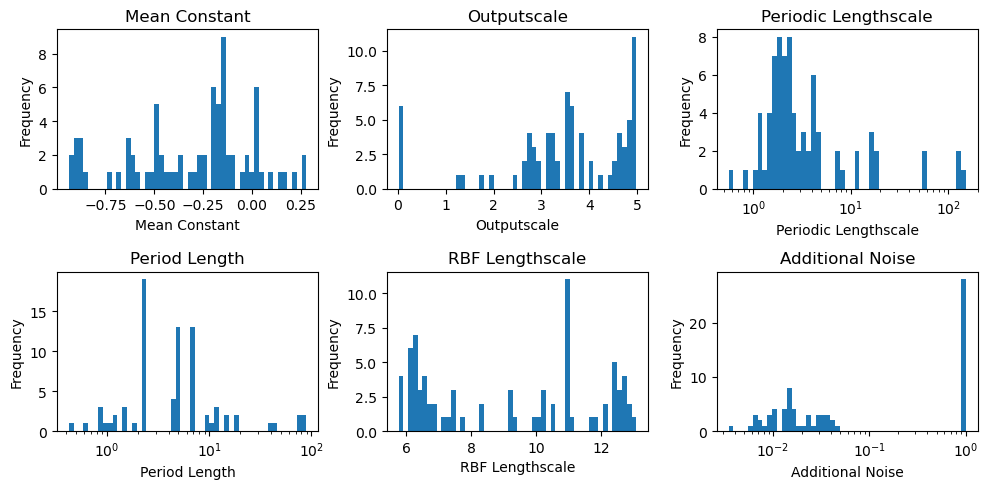

Text(0.5, 1.0, 'High Residuals')

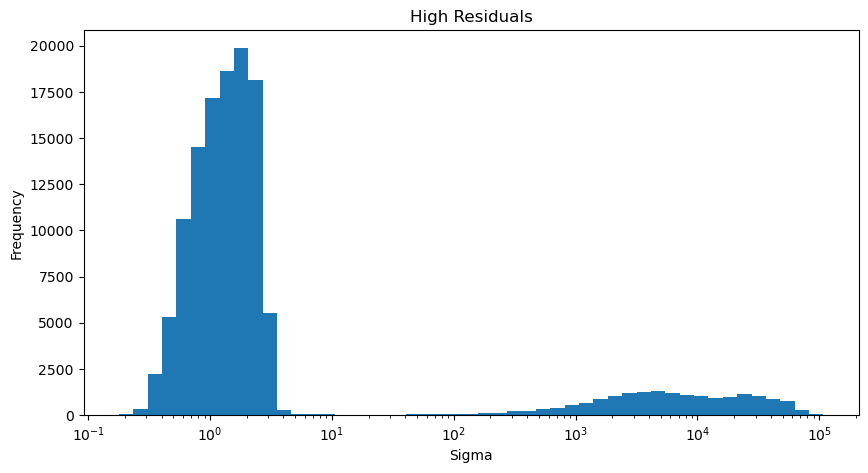

In [65]:
# Check all lists have the same length
print(len(mean_constants), len(outputscales), len(periodic_lengthscales), len(period_lengths), len(rbf_lengthscales), len(noises), len(high_residuals))
print(min(high_residuals), max(high_residuals))

# Plot parameters all in one plot, separate subplots for each parameter
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.hist(mean_constants, bins=50)
plt.xlabel("Mean Constant")
plt.ylabel("Frequency")
plt.title("Mean Constant")

plt.subplot(2,3,2)
plt.hist(outputscales, bins=50)
plt.xlabel("Outputscale")
plt.ylabel("Frequency")
plt.title("Outputscale")

plt.subplot(2,3,3)
plt.hist(periodic_lengthscales, bins=np.logspace(np.log10(min(periodic_lengthscales)), np.log10(max(periodic_lengthscales))))
plt.xscale('log')
plt.xlabel("Periodic Lengthscale")
plt.ylabel("Frequency")
plt.title("Periodic Lengthscale")

plt.subplot(2,3,4)
plt.hist(period_lengths, bins=np.logspace(np.log10(min(period_lengths)), np.log10(max(period_lengths)), 50))
plt.xscale('log')
plt.xlabel("Period Length")
plt.ylabel("Frequency")
plt.title("Period Length")

plt.subplot(2,3,5)
plt.hist(rbf_lengthscales, bins=50)
plt.xlabel("RBF Lengthscale")
plt.ylabel("Frequency")
plt.title("RBF Lengthscale")

plt.subplot(2,3,6)
plt.hist(noises, bins=np.logspace(np.log10(min(noises)), np.log10(max(noises))))
plt.xscale('log')
plt.xlabel("Additional Noise")
plt.ylabel("Frequency")
plt.title("Additional Noise")

plt.tight_layout()
plt.show()

# Plot histogram of high residuals
plt.figure(figsize=(10,5))
plt.hist(high_residuals, bins=np.logspace(np.log10(min(high_residuals)), np.log10(max(high_residuals)), 50))
plt.xlabel("Sigma")
plt.ylabel("Frequency")
plt.xscale('log')
plt.title("High Residuals")

### Write them to a file

In [63]:
# Write GP parameters and high_residuals to file in data folder as a csv with column names
save_dir = '../../data/synthetic_params/'
with open(save_dir + 'gp_parameters.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['file_number', 'mean_constant', 'outputscale', 'periodic_lengthscale', 'period_length', 'rbf_lengthscale', 'noise'])
    for i in range(len(mean_constants)):
        writer.writerow([i, mean_constants[i], outputscales[i], periodic_lengthscales[i], period_lengths[i], rbf_lengthscales[i], noises[i]])

with open(save_dir + 'high_residuals.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['high_residual'])
    for i in range(len(high_residuals)):
        writer.writerow([high_residuals[i]])

### Read parameters and generate a sample from distribution over parameters

In [19]:
# Function to fit a distribution and return parameters
def fit_best_distribution(
        data, 
        bins=100,
        dist_names=None,
        plot=False
    ):

    if dist_names is None:
        dist_names = ['norm', 'expon', 'lognorm', 'gamma', 'beta', 'uniform']
    
    best_fit_name = None
    best_fit_params = None
    best_sse = np.inf  # Smallest sum of squared errors

    # Histogram for calculating density
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins

    for dist_name in dist_names:
        try:
            dist = getattr(scipy.stats, dist_name)
            params = dist.fit(data)  # Fit the distribution
            pdf = dist.pdf(bin_centers, *params)
            sse = np.sum((hist - pdf) ** 2)
            
            if sse < best_sse:
                best_fit_name = dist_name
                best_fit_params = params
                best_sse = sse
        except Exception as e:
            print(f"Error fitting {dist_name}: {e}")

    if plot:
        plt.figure(figsize=(10,5))
        plt.hist(data, bins=bins, density=True, alpha=0.6)
        x = np.linspace(min(data), max(data), 1000)
        pdf = getattr(scipy.stats, best_fit_name).pdf(x, *best_fit_params)
        plt.plot(x, pdf, 'r', lw=2)
        plt.ylim(0, min(max(pdf), 30))
        plt.title(f"Best fit distribution: {best_fit_name}")
        plt.show()
    
    return best_fit_name, best_fit_params

# Function to sample from fitted distributions
def sample_from_distributions(
        data_dict,
        distribution_dict = None,
        ):
    
    samples = {}
    for key, values in data_dict.items():
        # Fit the distribution to the parameter
        if distribution_dict is not None and key in distribution_dict:
            dist_name, params = distribution_dict[key]
            dist = getattr(scipy.stats, dist_name)
        else:
            dist_name, params = fit_best_distribution(values)
            dist = getattr(scipy.stats, dist_name)
        
        # Sample new values
        samples[key] = dist.rvs(*params, size=1)
    return samples

# Function to sample high_residuals
def sample_high_residuals_random_signs(
        high_residuals, 
        num_lightcurves,
        distribution_dict=None,
    ):
    # Fit the best distribution to high residuals
    if distribution_dict is not None and 'high_residuals' in distribution_dict:
        dist_name, params = distribution_dict['high_residuals']
        dist = getattr(scipy.stats, dist_name)
    else:
        dist_name, params = fit_best_distribution(high_residuals)
        dist = getattr(scipy.stats, dist_name)

    # Decide a reasonable number of residuals to generate based on how many residuals were distributed among the lightcurves
    avg_num_residuals = len(high_residuals) / (num_lightcurves * 10)
    num_residuals = np.random.poisson(avg_num_residuals, size=None)

    # Sample total residuals
    residuals = dist.rvs(*params, size=num_residuals)
    
    # Randomly flip signs with 33% probability
    signs = np.random.choice([1, 1, -1], size=num_residuals)
    residuals *= signs
    
    return np.array(residuals)

### Fit distributions and write to files

78 78 78 78 78 78 1781
Fitting distribution for mean_constants


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


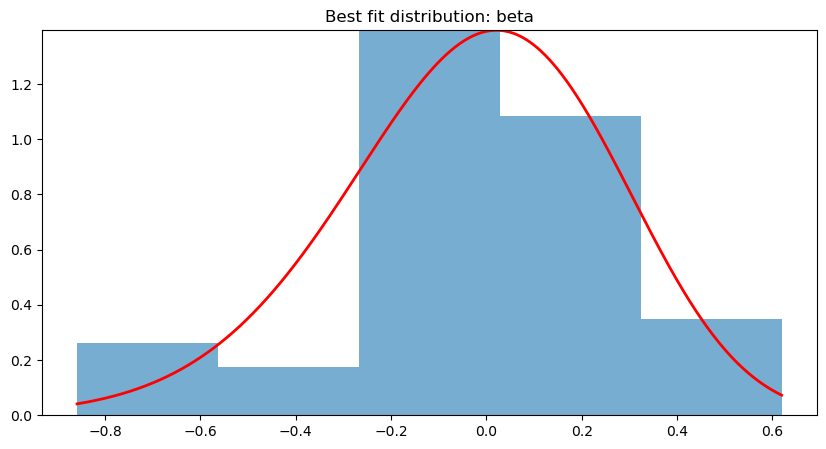

Fitting distribution for outputscales


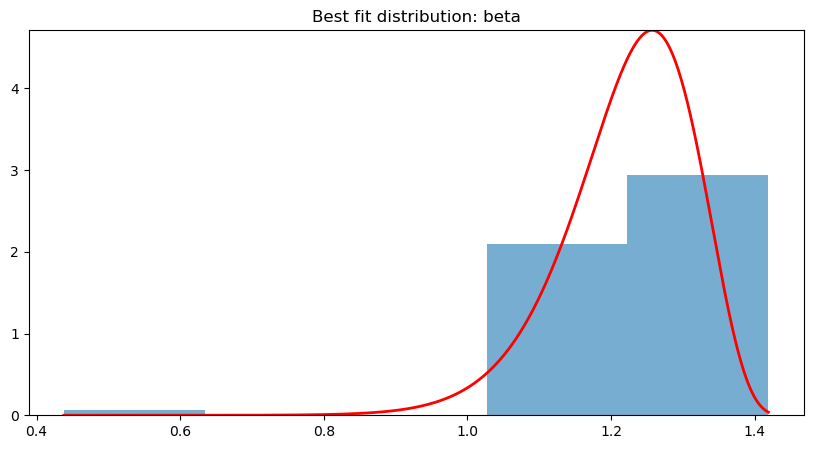

Fitting distribution for periodic_lengthscales


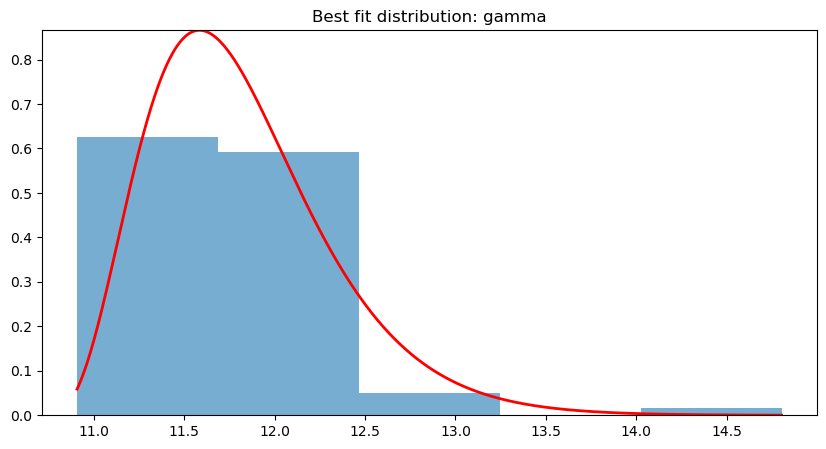

Fitting distribution for period_lengths


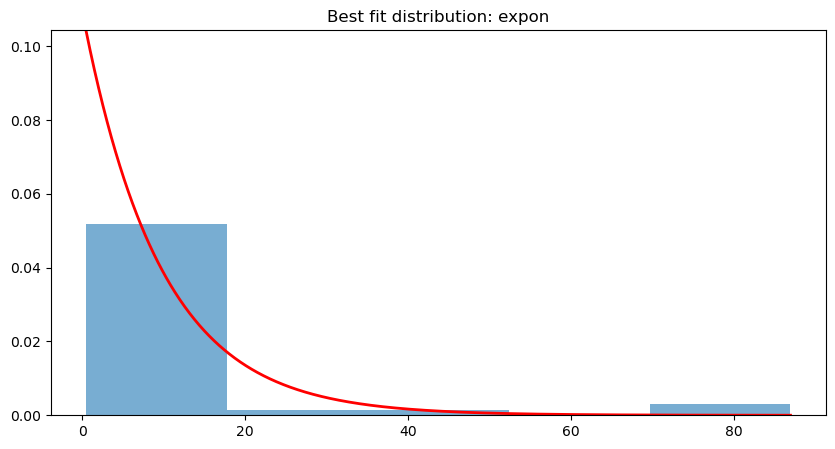

Fitting distribution for rbf_lengthscales


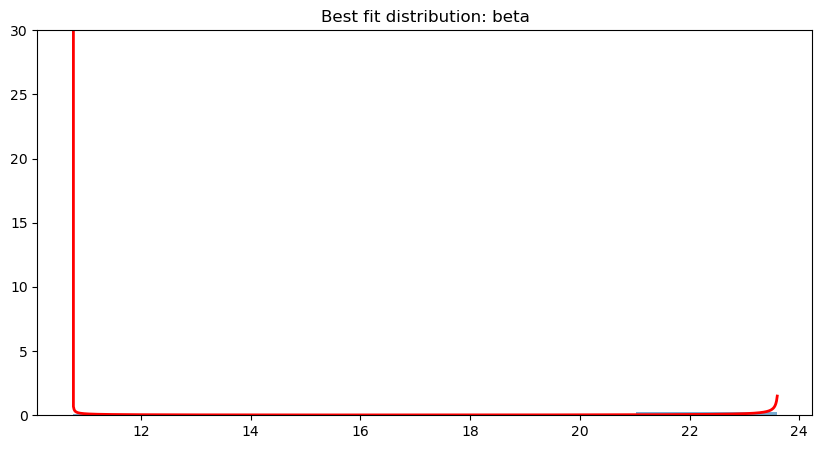

Fitting distribution for noises


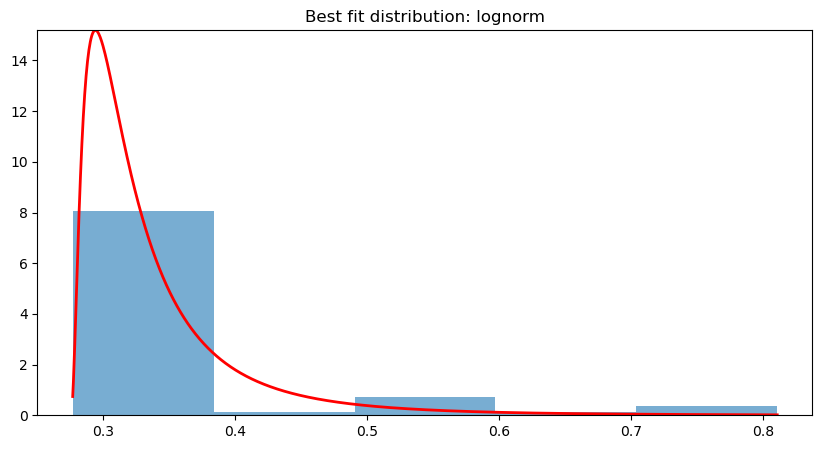

Fitting distribution for high_residuals


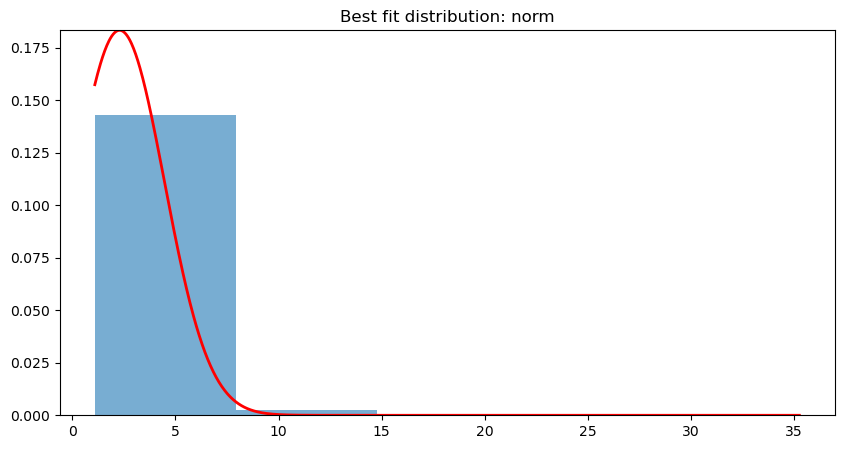

{'mean_constants': ('beta', (204642.318359748, 33.064307721163914, -10313.615649643669, 10315.252820214551)), 'outputscales': ('beta', (535187358.1042859, 6.785635661653205, -18577516.688189037, 18577518.146183576)), 'periodic_lengthscales': ('gamma', (4.753785546794085, 10.71207732395277, 0.23259164575091706)), 'period_lengths': ('expon', (0.430453896522522, 9.583156074468906)), 'rbf_lengthscales': ('beta', (0.3906972504357902, 0.17275680058092724, 10.75418186187744, 12.873463084356988)), 'noises': ('lognorm', (0.904877056323091, 0.2750279245292401, 0.04370426972014051)), 'high_residuals': ('norm', (2.2891774689899638, 2.1774900977106837))}


In [20]:
# Read GP parameters and high_residuals from files
mean_constants = []
outputscales = []
periodic_lengthscales = []
period_lengths = []
rbf_lengthscales = []
noises = []
high_residuals = []

save_dir = '../../data/synthetic_params/'

with open(save_dir + 'gp_parameters.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        mean_constants.append(float(row[1]))
        outputscales.append(float(row[2]))
        periodic_lengthscales.append(float(row[3]))
        period_lengths.append(float(row[4]))
        rbf_lengthscales.append(float(row[5]))
        noises.append(float(row[6]))

with open(save_dir + 'high_residuals.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        high_residuals.append(float(row[0]))

print(len(mean_constants), len(outputscales), len(periodic_lengthscales), len(period_lengths), len(rbf_lengthscales), len(noises), len(high_residuals))

# Write parameters and their distributions to a file
parameters = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'period_lengths': period_lengths,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises,
    'high_residuals': high_residuals
}

dists = {}
for key, values in parameters.items():
    # Fit the distribution
    print(f"Fitting distribution for {key}")
    dist_name, params = fit_best_distribution(values, bins=5, plot=True)
    dists[key] = (dist_name, params)

print(dists)
with open(save_dir + 'fitted_distributions.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['parameter', 'distribution', 'params'])
    for key, value in dists.items():
        writer.writerow([key, value[0], value[1]])

### Load distributions from file and generate a sample

In [21]:
# Create data dictionary with loaded parameters
data_dict = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'period_lengths': period_lengths,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises
}

# Load distributions from file
load_dists = {}
with open(save_dir + 'fitted_distributions.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0] == 'parameter':
            continue

        key = row[0]
        dist_name = row[1]
        params = tuple(map(float, row[2].strip('()').split(',')))

        load_dists[key] = (dist_name, params)

# Fit distributions and sample
sampled_data = sample_from_distributions(
    data_dict,
    load_dists
)

# Get residuals
sampled_residuals = sample_high_residuals_random_signs(
    high_residuals, 
    78,
    load_dists
)

print(sampled_data)
print(sampled_residuals)

{'mean_constants': array([0.23865585]), 'outputscales': array([1.0517638]), 'periodic_lengthscales': array([11.52622917]), 'period_lengths': array([0.88684885]), 'rbf_lengthscales': array([23.62189872]), 'noises': array([0.72785178])}
[]


### Generate lightcurve

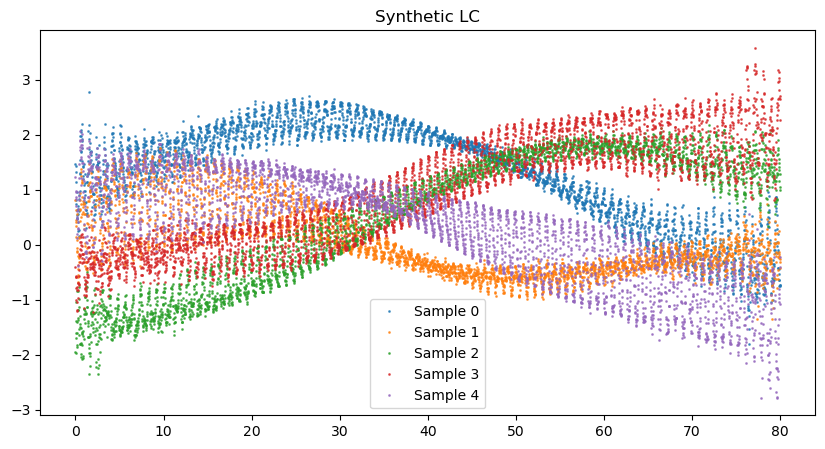

In [23]:
num_timesteps=3500
num_samples=5

# Define timesteps, y as Gaussian noise, and noise
x = torch.linspace(0, 80, num_timesteps).to(device)

# Get GP model
kernel = ParameterizedQuasiPeriodicKernel(
    period_length=sampled_data["period_lengths"], 
    periodic_lengthscale=sampled_data["periodic_lengthscales"], 
    rbf_lengthscale=sampled_data["rbf_lengthscales"]
).to(device)

# noise_vars = torch.tensor([sampled_data["noises"]] * num_timesteps).to(device)
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
#     noise=noise_vars, 
#     learn_additional_noise=False
# ).to(device)

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
likelihood.noise = sampled_data["noises"][0]

model = ParameterizedGPModel(
    kernel, 
    mean_constant=sampled_data["mean_constants"], 
    outputscale=sampled_data["outputscales"], 
    likelihood=likelihood
).to(device)

# Generate predictions
model.eval()
model.likelihood.eval()

with torch.no_grad():
    # Generate the GP predictions
    predictions = model.likelihood(model(x))
    samples = predictions.sample(torch.Size([num_samples]))
    mean = predictions.mean.cpu().numpy()

# Convert to numpy for further processing
x = x.detach().cpu().numpy()
samples = samples.detach().cpu().numpy()
for i in range(num_samples):
    # Add some high residuals randomly distributed
    num_high_residuals = len(sampled_residuals)
    high_residual_indices = np.random.choice(num_timesteps, num_high_residuals, replace=False)
    for j, idx in enumerate(high_residual_indices):
        samples[i, idx] += sampled_residuals[j]

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x, samples[i], '.', ms=2, alpha=0.7, label=f'Sample {i}')
plt.legend()
plt.title("Synthetic LC")
plt.show()

### Generate many samples from different lightcurves

{'mean_constants': array([0.01280453]), 'outputscales': array([1.2105366]), 'periodic_lengthscales': array([11.6370828]), 'period_lengths': array([6.59571324]), 'rbf_lengthscales': array([17.78514347]), 'noises': array([0.29771471])}
[-1.41729194  2.58936039 -0.8720244   2.30474432]
{'mean_constants': array([-0.43457042]), 'outputscales': array([1.33365225]), 'periodic_lengthscales': array([11.43625963]), 'period_lengths': array([3.05555732]), 'rbf_lengthscales': array([19.06127217]), 'noises': array([0.3572996])}
[]
{'mean_constants': array([-0.02456389]), 'outputscales': array([1.23697155]), 'periodic_lengthscales': array([12.91985698]), 'period_lengths': array([1.68016017]), 'rbf_lengthscales': array([21.82167711]), 'noises': array([0.29274448])}
[ 3.53327385 -4.93580025  3.53748896]
{'mean_constants': array([-0.25034323]), 'outputscales': array([1.2517404]), 'periodic_lengthscales': array([11.36132258]), 'period_lengths': array([12.87550722]), 'rbf_lengthscales': array([23.52984306

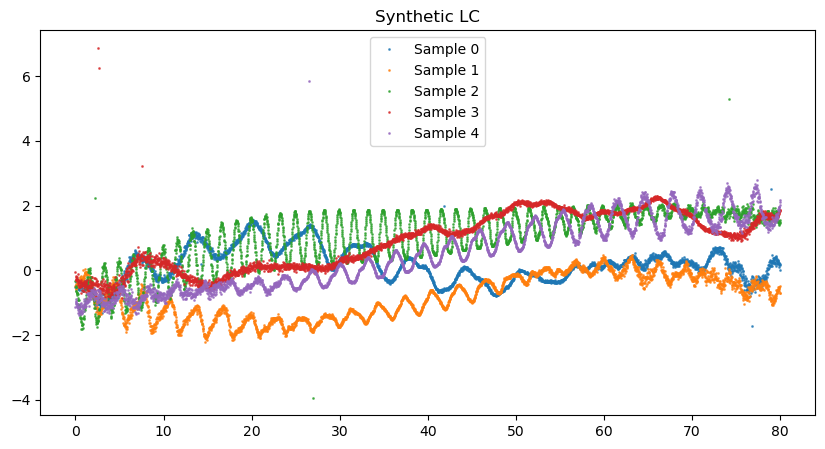

In [24]:
num_timesteps = 3500
num_samples = 5
lc_samples = []

# Create data dictionary with loaded parameters
data_dict = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'period_lengths': period_lengths,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises
}

# Load distributions from file
load_dists = {}
with open(save_dir + 'fitted_distributions.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0] == 'parameter':
            continue

        key = row[0]
        dist_name = row[1]
        params = tuple(map(float, row[2].strip('()').split(',')))

        load_dists[key] = (dist_name, params)

for i in range(num_samples):
    # Fit distributions and sample
    sampled_data = sample_from_distributions(
        data_dict,
        load_dists
    )

    # Get residuals
    sampled_residuals = sample_high_residuals_random_signs(
        high_residuals, 
        78,
        load_dists
    )

    print(sampled_data)
    print(sampled_residuals)

    # Define timesteps, y as Gaussian noise, and noise
    x = torch.linspace(0, 80, num_timesteps).to(device)

    # Get GP model
    kernel = ParameterizedQuasiPeriodicKernel(
        period_length=sampled_data["period_lengths"], 
        periodic_lengthscale=sampled_data["periodic_lengthscales"], 
        rbf_lengthscale=sampled_data["rbf_lengthscales"]
    ).to(device)

    # noise_vars = torch.tensor([sampled_data["noises"]] * num_timesteps).to(device)
    # likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
    #     noise=noise_vars, 
    #     learn_additional_noise=False
    # ).to(device)

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    likelihood.noise = sampled_data["noises"][0]

    model = ParameterizedGPModel(
        kernel, 
        mean_constant=sampled_data["mean_constants"], 
        outputscale=sampled_data["outputscales"], 
        likelihood=likelihood
    ).to(device)

    # Generate predictions
    model.eval()
    model.likelihood.eval()

    with torch.no_grad():
        # Generate the GP predictions
        predictions = model.likelihood(model(x))
        samples = predictions.sample(torch.Size([1]))
        mean = predictions.mean.cpu().numpy()

    # Convert to numpy for further processing
    x = x.detach().cpu().numpy()
    samples = samples.detach().cpu().numpy()
    for i in range(1):
        # Add some high residuals randomly distributed
        num_high_residuals = len(sampled_residuals)
        high_residual_indices = np.random.choice(num_timesteps, num_high_residuals, replace=False)
        for j, idx in enumerate(high_residual_indices):
            samples[i, idx] += sampled_residuals[j]

    lc_samples.append(samples[0])

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x, lc_samples[i], '.', ms=2, alpha=0.7, label=f'Sample {i}')
plt.legend()
plt.title("Synthetic LC")
plt.show()